In [56]:
import numpy as np
import pandas as pd
df = pd.read_csv(r"C:\Users\gallo\Downloads\archive(3)\Airports2.csv")

In [57]:
# Supponiamo che il tuo DataFrame originale sia df
alpha = 0.4  # Peso per il numero di voli
beta = 0.6   # Peso per il numero di passeggeri

# Aggrega i dati per coppia di aeroporti, sommando i voli e i passeggeri
df_agg = df.groupby(['Origin_airport', 'Destination_airport'], as_index=False).agg({
    'Flights': 'sum',       # Somma il numero di voli
    'Passengers': 'sum'     # Somma il numero di passeggeri
})

# Calcola il peso combinato per ogni arco
df_agg['Weight'] = alpha * df_agg['Flights'] + beta * df_agg['Passengers']

# Creazione della lista di adiacenza pesata
adj_list_weighted = {}
for index, row in df_agg.iterrows():
    origin = row['Origin_airport']
    destination = row['Destination_airport']
    weight = row['Weight']
    
    # Aggiungi l'arco nella lista di adiacenza
    if origin not in adj_list_weighted:
        adj_list_weighted[origin] = {}
    if destination not in adj_list_weighted:
        adj_list_weighted[destination] = {}
    
    # Poiché il grafo è non diretto, aggiungi l'arco in entrambe le direzioni
    adj_list_weighted[origin][destination] = weight
    adj_list_weighted[destination][origin] = weight

# Visualizza la lista di adiacenza pesata
print(f"Numero di nodi: {len(adj_list_weighted)}")
print(f"Numero di archi: {sum(len(neighbors) for neighbors in adj_list_weighted.values()) // 2}")


Numero di nodi: 727
Numero di archi: 23125


In [58]:
# Numero di archi prima dell'aggregazione
# Per ogni coppia Origin_airport e Destination_airport, contiamo come un arco
num_edges_before = len(df)

# Aggregazione per ridurre gli archi
alpha = 0.4  # Peso per il numero di voli
beta = 0.6   # Peso per il numero di passeggeri

# Raggruppamento per coppia di aeroporti
df_agg = df.groupby(['Origin_airport', 'Destination_airport'], as_index=False).agg({
    'Flights': 'sum',
    'Passengers': 'sum'
})

# Calcolo del peso combinato
df_agg['Weight'] = alpha * df_agg['Flights'] + beta * df_agg['Passengers']

# Numero di archi dopo l'aggregazione
num_edges_after = len(df_agg)

# Creazione della lista di adiacenza pesata
adj_list_weighted = {}
for index, row in df_agg.iterrows():
    origin = row['Origin_airport']
    destination = row['Destination_airport']
    weight = row['Weight']
    
    if origin not in adj_list_weighted:
        adj_list_weighted[origin] = {}
    if destination not in adj_list_weighted:
        adj_list_weighted[destination] = {}
    
    adj_list_weighted[origin][destination] = weight
    adj_list_weighted[destination][origin] = weight

# Output
print(f"Numero di archi prima dell'aggregazione: {num_edges_before}")
print(f"Numero di archi dopo l'aggregazione: {num_edges_after}")
print(f"Riduzione degli archi: {num_edges_before - num_edges_after} ({((num_edges_before - num_edges_after) / num_edges_before) * 100:.2f}%)")


Numero di archi prima dell'aggregazione: 3606803
Numero di archi dopo l'aggregazione: 36719
Riduzione degli archi: 3570084 (98.98%)


In [59]:
df_agg.head()

,Origin_airport,Destination_airport,Flights,Passengers,Weight
0,1B1,BDL,1,1,1.0
1,ABE,ABE,26,2524,1524.8
2,ABE,ACT,1,0,0.4
3,ABE,ACY,1,73,44.2
4,ABE,ADS,1,0,0.4


In [60]:
from collections import defaultdict
import random
import time

def compute_modularity(adj_list, communities, m):
    """Calcola la modularità pesata del grafo."""
    Q = 0.0
    for node in adj_list:
        for neighbor, weight in adj_list[node].items():
            if communities[node] == communities[neighbor]:  # Se sono nella stessa comunità
                ki = sum(adj_list[node].values())  # Grado pesato del nodo
                kj = sum(adj_list[neighbor].values())  # Grado pesato del vicino
                Q += weight - (ki * kj) / (2 * m)
    return Q / (2 * m)

def louvain_with_max_iterations(adj_list, max_iterations=300):
    """Implementazione dell'algoritmo Louvain con un massimo di iterazioni."""
    # Inizializza ogni nodo in una comunità separata
    communities = {node: i for i, node in enumerate(adj_list)}
    m = sum(sum(neighbors.values()) for neighbors in adj_list.values()) / 2  # Somma totale dei pesi

    print(f"Numero totale di nodi: {len(adj_list)}, Peso totale del grafo (2m): {2 * m}")

    improvement = True
    iteration = 0
    modularity_history = []  # Storico della modularità per monitorare i miglioramenti

    while iteration < max_iterations:
        iteration += 1
        improvement = False
        nodes = list(adj_list.keys())
        random.shuffle(nodes)  # Ordine casuale

        print(f"\nInizio iterazione {iteration} - Numero di nodi: {len(nodes)}")

        for node in nodes:
            best_community = communities[node]
            best_increase = 0
            current_community = communities[node]

            neighbor_communities = defaultdict(float)
            for neighbor, weight in adj_list[node].items():
                neighbor_communities[communities[neighbor]] += weight

            for community, weight_sum in neighbor_communities.items():
                ki = sum(adj_list[node].values())
                sigma_tot = sum(sum(adj_list[n].values()) for n in adj_list if communities[n] == community)
                delta_Q = (weight_sum - (ki * sigma_tot) / (2 * m))

                if delta_Q > best_increase:
                    best_community = community
                    best_increase = delta_Q

            if best_community != current_community:
                communities[node] = best_community
                improvement = True

        # Calcolo della modularità
        current_modularity = compute_modularity(adj_list, communities, m)
        modularity_history.append(current_modularity)

        print(f"Iterazione {iteration} - Modularità: {current_modularity:.6f}")
        print(f"Tempo trascorso finora: {time.time() - start_time:.2f} secondi")

    print(f"\nNumero massimo di iterazioni ({max_iterations}) raggiunto.")
    print("Algoritmo terminato.")

    # Raggruppa i nodi per comunità
    community_groups = defaultdict(list)
    for node, community in communities.items():
        community_groups[community].append(node)

    return list(community_groups.values())

# --- Esecuzione dell'algoritmo ---
start_time = time.time()
communities = louvain_with_max_iterations(adj_list_weighted, max_iterations=300)
end_time = time.time()

# Stampa le comunità rilevate
print(f"Numero di comunità rilevate: {len(communities)}")
for i, community in enumerate(communities):
    print(f"Comunità {i+1}: {len(community)} nodi")
print(f"Tempo totale di esecuzione: {end_time - start_time:.2f} secondi")


Numero totale di nodi: 727, Peso totale del grafo (2m): 5876088243.0

Inizio iterazione 1 - Numero di nodi: 727
Iterazione 1 - Modularità: 0.146400
Tempo trascorso finora: 2.64 secondi

Inizio iterazione 2 - Numero di nodi: 727
Iterazione 2 - Modularità: 0.218556
Tempo trascorso finora: 4.00 secondi

Inizio iterazione 3 - Numero di nodi: 727
Iterazione 3 - Modularità: 0.235928
Tempo trascorso finora: 5.06 secondi

Inizio iterazione 4 - Numero di nodi: 727
Iterazione 4 - Modularità: 0.238367
Tempo trascorso finora: 6.05 secondi

Inizio iterazione 5 - Numero di nodi: 727
Iterazione 5 - Modularità: 0.242832
Tempo trascorso finora: 7.59 secondi

Inizio iterazione 6 - Numero di nodi: 727
Iterazione 6 - Modularità: 0.242896
Tempo trascorso finora: 8.73 secondi

Inizio iterazione 7 - Numero di nodi: 727
Iterazione 7 - Modularità: 0.242897
Tempo trascorso finora: 9.90 secondi

Inizio iterazione 8 - Numero di nodi: 727
Iterazione 8 - Modularità: 0.242897
Tempo trascorso finora: 11.06 secondi

I

In [61]:
def print_communities(communities):
    """
    Stampa tutte le comunità rilevate.
    """
    print(f"Numero totale di comunità rilevate: {len(communities)}")
    for i, community in enumerate(communities):
        print(f"Comunità {i+1} ({len(community)} nodi):")
        print(", ".join(community))
        print("-" * 50)

# Assumendo che `communities` contenga le comunità rilevate dal Louvain
print_communities(communities)


Numero totale di comunità rilevate: 22
Comunità 1 (251 nodi):
1B1, BDL, ABE, ACY, AGS, ALB, ATL, ATW, AVL, AVP, AZO, BFM, BGM, BGR, BHM, BMI, BNA, BOS, BTV, BUF, BWI, CAE, CAK, CHA, CHO, CHS, CLE, CLT, CMH, CRW, CSG, CVG, DAY, DCA, DHN, DTW, ELM, ERI, EWR, FAY, FLL, FWA, GPT, GRR, GSO, GSP, GYY, HSV, HVN, IAD, ILG, ILM, IND, IPT, ITH, JAX, JST, LAN, LCK, LEX, LGA, LYH, MBS, MCN, MCO, MDT, MEM, MHT, MIA, MKE, MOB, MSN, MYR, ORD, ORH, PBI, PGD, PHL, PIT, PVD, PWM, RDG, RDU, RFD, RIC, ROA, ROC, SAV, SBN, SCE, SFB, SYR, TOL, TPA, TTN, TVC, TYS, YNG, PNS, CKB, EVV, GNV, GTR, LAL, MGM, OPF, YIP, ABY, BQK, CPS, MFD, PFN, TLH, VLD, CMI, TMB, CRE, EWN, GFL, HKY, ISO, NZC, OAJ, PGV, RWI, UCA, XXW, FNT, BTL, GLH, MKG, MQT, ANB, ART, BDR, LAF, MEI, NIP, PIB, TUP, AGC, BKL, FLO, NQA, AHN, AID, AIY, OGS, PBG, RUT, DBQ, SYI, DOV, OSH, AND, AOO, CBE, OKK, APF, BFD, EYW, APN, ESC, HGR, ASL, ASN, MVN, AUO, AYS, BKG, BMG, DCU, GDC, NQX, RMG, SHD, SSI, UBS, ATO, BVX, AUG, RKD, AXV, PKB, JHW, BFR, HUA, ORL

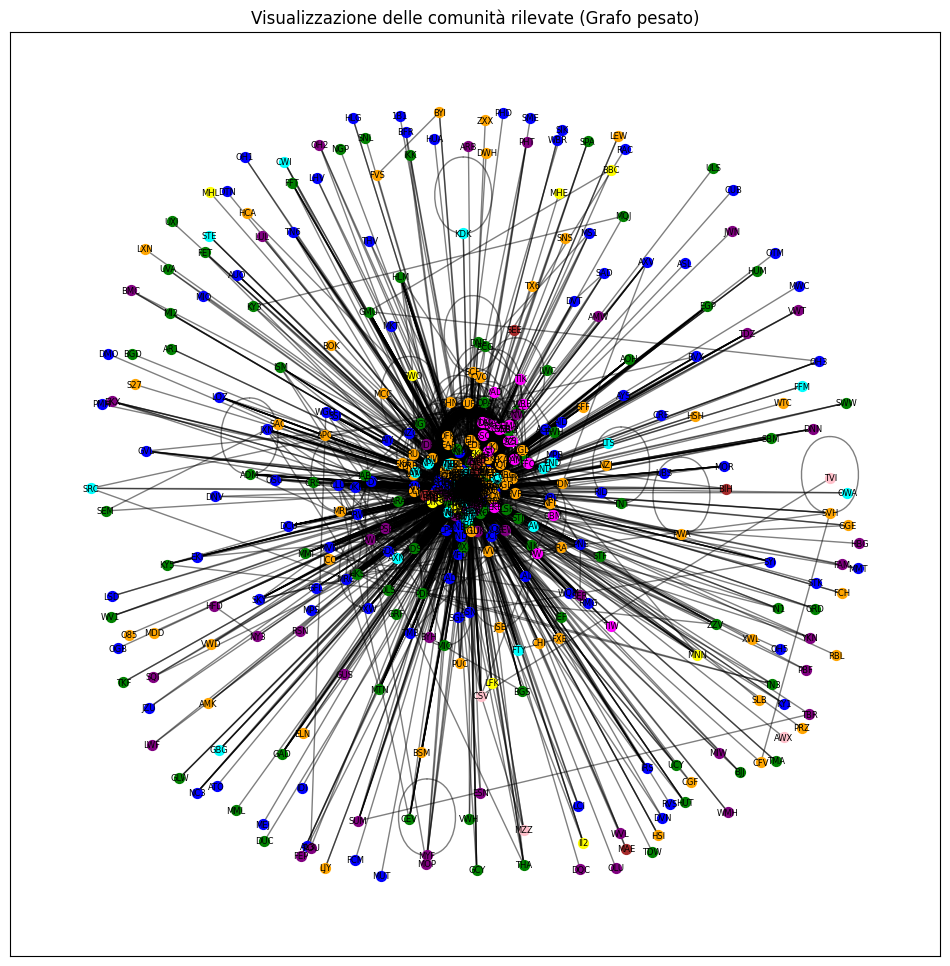

In [63]:
import matplotlib.pyplot as plt
import networkx as nx
from itertools import cycle

# Creazione del grafo pesato
G = nx.Graph()
for node, neighbors in adj_list_weighted.items():
    for neighbor, weight in neighbors.items():
        G.add_edge(node, neighbor, weight=weight)

# Assicurati di avere le comunità rilevate
# communities = louvain_simplified(adj_list_weighted)  # Risultato del tuo algoritmo

# Genera colori unici per ogni comunità
colors = cycle(['blue', 'green', 'purple', 'orange', 'cyan', 'yellow', 'magenta', 'pink', 'brown'])

# Crea un dizionario per assegnare colori ai nodi in base alla comunità
node_colors = {}
for i, community in enumerate(communities):
    color = next(colors)
    for node in community:
        node_colors[node] = color

# Posizionamento dei nodi
pos = nx.spring_layout(G, seed=42, k=0.5)  # k regola la distanza tra nodi

# Disegna il grafo
plt.figure(figsize=(12, 12))

# Disegna i nodi per comunità
for community in communities:
    nx.draw_networkx_nodes(G, pos, nodelist=community, 
                           node_color=node_colors[community[0]], node_size=50)

# Disegna gli archi
nx.draw_networkx_edges(G, pos, alpha=0.5)

# Aggiungi etichette ai nodi (opzionale)
nx.draw_networkx_labels(G, pos, font_size=6)

plt.title("Visualizzazione delle comunità rilevate (Grafo pesato)")
plt.show()


In [67]:
def analyze_communities(communities, city1, city2):
    """
    Analizza le comunità nella rete di voli e risponde alla domanda specifica.

    Input:
        - communities: Lista delle comunità rilevate
        - city1: Nome della prima città
        - city2: Nome della seconda città

    Output:
        - Numero totale di comunità e città appartenenti a ciascuna comunità
        - Indica se city1 e city2 appartengono alla stessa comunità
    """
    # 1. Conta le comunità e le città in ogni comunità
    print(f"Numero totale di comunità: {len(communities)}")
    for i, community in enumerate(communities):
        print(f"Comunità {i+1}: {len(community)} città")

    # 2. Verifica se city1 e city2 appartengono alla stessa comunità
    community_of_city1 = None
    community_of_city2 = None

    for i, community in enumerate(communities):
        if city1 in community:
            community_of_city1 = i
        if city2 in community:
            community_of_city2 = i

    if community_of_city1 is not None and community_of_city2 is not None:
        if community_of_city1 == community_of_city2:
            print(f"{city1} e {city2} appartengono alla stessa comunità ({community_of_city1 + 1}).")
        else:
            print(f"{city1} e {city2} appartengono a comunità diverse ({community_of_city1 + 1} e {community_of_city2 + 1}).")
    else:
        print(f"Una o entrambe le città ({city1}, {city2}) non sono nella rete di voli.")


In [71]:
a = analyze_communities(communities , 'SNL', 'MOB')

Numero totale di comunità: 22
Comunità 1: 251 città
Comunità 2: 122 città
Comunità 3: 75 città
Comunità 4: 162 città
Comunità 5: 45 città
Comunità 6: 16 città
Comunità 7: 16 città
Comunità 8: 4 città
Comunità 9: 6 città
Comunità 10: 2 città
Comunità 11: 5 città
Comunità 12: 2 città
Comunità 13: 3 città
Comunità 14: 1 città
Comunità 15: 2 città
Comunità 16: 3 città
Comunità 17: 3 città
Comunità 18: 2 città
Comunità 19: 2 città
Comunità 20: 2 città
Comunità 21: 1 città
Comunità 22: 2 città
SNL e MOB appartengono a comunità diverse (2 e 1).


In [72]:
def analyze_community_statistics(df, communities):
    """Analizza le statistiche per ogni comunità."""
    for i, community in enumerate(communities):
        # Filtra il DataFrame per i nodi della comunità
        community_df = df[df['Origin_airport'].isin(community) & df['Destination_airport'].isin(community)]
        
        # Calcola statistiche aggregate
        total_flights = community_df['Flights'].sum()
        total_passengers = community_df['Passengers'].sum()
        avg_distance = community_df['Distance'].mean()
        
        print(f"Comunità {i+1}:")
        print(f"  Numero di nodi: {len(community)}")
        print(f"  Voli totali: {total_flights}")
        print(f"  Passeggeri totali: {total_passengers}")
        print(f"  Distanza media: {avg_distance:.2f} km")
        print("-" * 50)

# Esempio di utilizzo
analyze_community_statistics(df, communities)


Comunità 1:
  Numero di nodi: 251
  Voli totali: 54846572
  Passeggeri totali: 3580498199
  Distanza media: 456.32 km
--------------------------------------------------
Comunità 2:
  Numero di nodi: 122
  Voli totali: 5464593
  Passeggeri totali: 260075433
  Distanza media: 277.10 km
--------------------------------------------------
Comunità 3:
  Numero di nodi: 75
  Voli totali: 1802401
  Passeggeri totali: 83060797
  Distanza media: 252.50 km
--------------------------------------------------
Comunità 4:
  Numero di nodi: 162
  Voli totali: 20933237
  Passeggeri totali: 1461344472
  Distanza media: 642.51 km
--------------------------------------------------
Comunità 5:
  Numero di nodi: 45
  Voli totali: 1316272
  Passeggeri totali: 48839828
  Distanza media: 217.30 km
--------------------------------------------------
Comunità 6:
  Numero di nodi: 16
  Voli totali: 1183766
  Passeggeri totali: 96968146
  Distanza media: 320.48 km
--------------------------------------------------


In [73]:
def analyze_geographic_distribution(df, communities):
    """Analizza la distribuzione geografica delle comunità."""
    for i, community in enumerate(communities):
        # Filtra il DataFrame per i nodi della comunità
        community_df = df[df['Origin_airport'].isin(community)]
        
        # Ottieni le città e i loro conteggi
        cities = community_df['Origin_city'].value_counts()
        
        print(f"Comunità {i+1}:")
        print(f"  Città principali (per frequenza):")
        print(cities.head(5))  # Mostra le prime 5 città
        print("-" * 50)

# Esempio di utilizzo
analyze_geographic_distribution(df, communities)


Comunità 1:
  Città principali (per frequenza):
Origin_city
Chicago, IL       158496
Atlanta, GA       131046
Detroit, MI       107406
Washington, DC     94977
Charlotte, NC      85615
Name: count, dtype: int64
--------------------------------------------------
Comunità 2:
  Città principali (per frequenza):
Origin_city
Dallas, TX         109740
Houston, TX         82005
Austin, TX          22012
San Antonio, TX     21442
El Paso, TX         16822
Name: count, dtype: int64
--------------------------------------------------
Comunità 3:
  Città principali (per frequenza):
Origin_city
St. Louis, MO      76689
Kansas City, MO    39024
Chicago, IL        27654
Omaha, NE          15944
Des Moines, IA     10916
Name: count, dtype: int64
--------------------------------------------------
Comunità 4:
  Città principali (per frequenza):
Origin_city
Los Angeles, CA      87299
Phoenix, AZ          71149
Las Vegas, NV        61993
San Francisco, CA    57206
Seattle, WA          55757
Name: count, d